In [1]:
%matplotlib inline

In [11]:
import numpy as np
import random
import torch
import torch.nn as nn            
import torch.optim as optim      
import torch.nn.functional as F  
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import time
from matplotlib import rc

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#number of epoch:
epoch = 3

In [3]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()
            self.labels.append(label)

    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [4]:
# Load the training set:
trainset = MNIST(
    root='./mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)

trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# Load the testset:
testset = MNIST(
    root='./mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)

testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [12]:
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()

        #set seed
        random.seed(100)
        torch.manual_seed(100)

        # conv layers: feature extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            #nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        # fc layers: classifier
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 300),
            nn.ReLU(),
            #nn.Dropout(),
            nn.Linear(300, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [6]:
#define a function to compute average loss and accuracy rate
def result_hinge(loader):
    model.eval()
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            sum_loss += nn.MultiMarginLoss(p=2,reduction='sum')(output, target).item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    return (sum_loss/len(loader.dataset)), (100. * correct / len(loader.dataset)), correct, len(loader.dataset) 

# squared hinge loss with l1 relularization

In [7]:
#define the hinge loss function
def square_hinge_loss(output, target):
    output_y = output[torch.arange(0,target.size(0)).long(), target.data].view(-1,1)
    loss = output - output_y + 1
    loss[torch.arange(0, target.size(0)).long(), target.data] = 0
    loss[loss<0]=0
    
    return torch.sum(loss**2)

In [8]:
#create an array of regularization parameters from 0 to 0.03 with step size 0.001
reg_params = np.linspace(0, 0.03, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_L1 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_L1 = []

#initiate a list storing training accuracy for different reg_param
train_acc_L1 = []

#initiate a list storing test accuracy for different reg_param
test_acc_L1 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_L1 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L1 = []

In [9]:
for reg_param in reg_params:
    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L1 norm of weight matrix on the last layer 
            l1_norm = torch.norm(model.fc_layers[-1].weight, p=1)
            
            #compute loss
            loss = square_hinge_loss(output, target)/target.size(0)   + reg_param*l1_norm
            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_L1.append(result_train[0])
    test_ave_loss_L1.append(result_test[0])
    train_acc_L1.append(result_train[1])
    test_acc_L1.append(result_test[1])
    matrix_norm_L1.append(np.linalg.norm(model.fc_layers[-1].weight.cpu().detach().numpy()))
    listoflist_L1.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))
    print('train_ave_loss_L1',train_ave_loss_L1)

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.971075
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.298104
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.506938
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.582439
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.311650
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.267367
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.236400
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.124812
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.174853
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.224026
4.71s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.192762
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.099457
Regularization par

Regularization parameter: 0.003 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.432020
4.21s
Regularization parameter: 0.003 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.392773
Regularization parameter: 0.003 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.294262
Regularization parameter: 0.003 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.292488
Regularization parameter: 0.003 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.248163
Regularization parameter: 0.003 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.210248
Regularization parameter: 0.003 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.179372
Regularization parameter: 0.003 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.567546
Regularization parameter: 0.003 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.178709
Regularization parameter: 0.003 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.378599
4.40s
Regularization parameter: 0.003 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.212856
Regularization parameter: 0.003 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.278063
Regulariz

Regularization parameter: 0.006 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.220409
Regularization parameter: 0.006 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.608424
Regularization parameter: 0.006 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.203838
Regularization parameter: 0.006 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.440685
4.56s
Regularization parameter: 0.006 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.257001
Regularization parameter: 0.006 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.335790
Regularization parameter: 0.006 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.445120
Regularization parameter: 0.006 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.296284
Regularization parameter: 0.006 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.205386
Regularization parameter: 0.006 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.422081
Regularization parameter: 0.006 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.355326
Regularization parameter: 0.006 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.215083
Regularizatio

4.48s
Regularization parameter: 0.009 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.281754
Regularization parameter: 0.009 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.380441
Regularization parameter: 0.009 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.467366
Regularization parameter: 0.009 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.328869
Regularization parameter: 0.009 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.222426
Regularization parameter: 0.009 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.424288
Regularization parameter: 0.009 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.374633
Regularization parameter: 0.009 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.244189
Regularization parameter: 0.009 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.301861
Regularization parameter: 0.009 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.253741
4.52s

Test set: Average loss: 0.0135, Accuracy: 9697/10000 (97%)

train_ave_loss_L1 [0.008281064413990437, 0.009452169128973037, 0.01100007974524051, 0.011976110033535709, 0.01

Regularization parameter: 0.012 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.403869
Regularization parameter: 0.012 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.506241
Regularization parameter: 0.012 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.359843
Regularization parameter: 0.012 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.238930
Regularization parameter: 0.012 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.406039
Regularization parameter: 0.012 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.397450
Regularization parameter: 0.012 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.266341
Regularization parameter: 0.012 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.315474
Regularization parameter: 0.012 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.268241
4.30s

Test set: Average loss: 0.0138, Accuracy: 9693/10000 (97%)

train_ave_loss_L1 [0.008281064413990437, 0.009452169128973037, 0.01100007974524051, 0.011976110033535709, 0.013215926541946829, 0.013985818937793375, 0.014583101227134467, 0.015063597352864841, 0.

4.59s
Regularization parameter: 0.015 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.326239
Regularization parameter: 0.015 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.428343
Regularization parameter: 0.015 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.527744
Regularization parameter: 0.015 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.379329
Regularization parameter: 0.015 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.246571
Regularization parameter: 0.015 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.409288
Regularization parameter: 0.015 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.414726
Regularization parameter: 0.015 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.273284
Regularization parameter: 0.015 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.308975
Regularization parameter: 0.015 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.287980
4.37s

Test set: Average loss: 0.0138, Accuracy: 9691/10000 (97%)

train_ave_loss_L1 [0.008281064413990437, 0.009452169128973037, 0.01100007974524051, 0.011976110033535709, 0.01

Regularization parameter: 0.018 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.698477
Regularization parameter: 0.018 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.285939
Regularization parameter: 0.018 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.538399
4.47s
Regularization parameter: 0.018 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.349972
Regularization parameter: 0.018 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.447807
Regularization parameter: 0.018 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.510585
Regularization parameter: 0.018 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.387446
Regularization parameter: 0.018 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.247987
Regularization parameter: 0.018 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.390340
Regularization parameter: 0.018 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.413426
Regularization parameter: 0.018 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.262525
Regularization parameter: 0.018 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.302051
Regularizatio

4.60s
Regularization parameter: 0.021 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.466266
Regularization parameter: 0.021 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.378144
Regularization parameter: 0.021 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.359653
Regularization parameter: 0.021 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.425460
Regularization parameter: 0.021 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.284356
Regularization parameter: 0.021 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.315168
Regularization parameter: 0.021 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.713309
Regularization parameter: 0.021 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.302638
Regularization parameter: 0.021 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.550541
4.48s
Regularization parameter: 0.021 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.375968
Regularization parameter: 0.021 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.436587
Regularization parameter: 0.021 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.544648
Regulariz

Regularization parameter: 0.024 Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.267989
Regularization parameter: 0.024 Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.075555
Regularization parameter: 0.024 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.859502
Regularization parameter: 0.024 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.825704
Regularization parameter: 0.024 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.714267
Regularization parameter: 0.024 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.535037
Regularization parameter: 0.024 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.680476
Regularization parameter: 0.024 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.615374
4.51s
Regularization parameter: 0.024 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.459888
Regularization parameter: 0.024 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.389256
Regularization parameter: 0.024 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.368559
Regularization parameter: 0.024 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.437628
Regularizati


Test set: Average loss: 0.0152, Accuracy: 9663/10000 (97%)

train_ave_loss_L1 [0.008281064413990437, 0.009452169128973037, 0.01100007974524051, 0.011976110033535709, 0.013215926541946829, 0.013985818937793375, 0.014583101227134467, 0.015063597352864841, 0.015073462093745668, 0.01516144849335154, 0.015263297972207268, 0.015332203572615982, 0.01536654927233855, 0.015451250860343376, 0.01546810204597811, 0.015519966731903454, 0.015562347318915029, 0.01588620252919694, 0.015974459544196726, 0.01618701728476832, 0.016579372041858734, 0.016666501611533265, 0.016753613388662537, 0.01697733266974489, 0.017107790105851988, 0.01704988018249472, 0.017135734559906024]
Regularization parameter: 0.027 Train Epoch: 1 [0/60000 (0%)]	Loss: 11.330782
Regularization parameter: 0.027 Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.641917
Regularization parameter: 0.027 Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.276499
Regularization parameter: 0.027 Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.105732
Regularizat

Regularization parameter: 0.029 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.347822
Regularization parameter: 0.029 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.543318
4.52s
Regularization parameter: 0.029 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.385541
Regularization parameter: 0.029 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.428881
Regularization parameter: 0.029 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.563176
Regularization parameter: 0.029 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.395562
Regularization parameter: 0.029 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.244302
Regularization parameter: 0.029 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.396086
Regularization parameter: 0.029 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.433231
Regularization parameter: 0.029 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.293425
Regularization parameter: 0.029 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.318092
Regularization parameter: 0.029 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.312667
4.32s

Test s

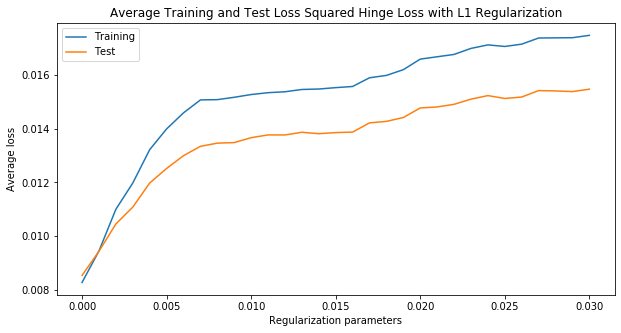

In [10]:
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title('Average Training and Test Loss Squared Hinge Loss with L1 Regularization')
plt.plot(reg_params, train_ave_loss_L1, label="Training")
plt.plot(reg_params, test_ave_loss_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

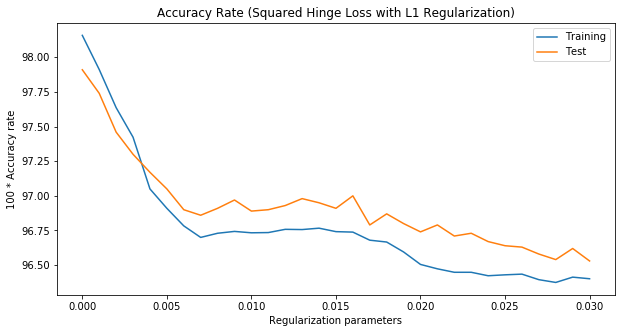

In [11]:
#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy Rate (Squared Hinge Loss with L1 Regularization)")
plt.plot(reg_params, train_acc_L1, label="Training")
plt.plot(reg_params, test_acc_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

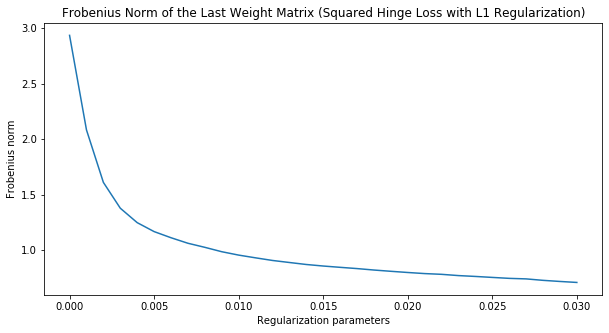

In [12]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Frobenius Norm of the Last Weight Matrix (Squared Hinge Loss with L1 Regularization)")
plt.plot(reg_params, matrix_norm_L1)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

In [13]:
#number of epoch:
epoch1 = 10

In [14]:
reg_params1 = np.linspace(0.02, 0.03, num=11, endpoint=True)
#initiate a list storing training average loss for different reg_param
train_ave_loss_L1_1 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_L1_1 = []

#initiate a list storing training accuracy for different reg_param
train_acc_L1_1 = []

#initiate a list storing test accuracy for different reg_param
test_acc_L1_1 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_L1_1 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L1_1 = []

In [15]:
for reg_param in reg_params1:
    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch1):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L1 norm of weight matrix on the last layer 
            l1_norm = torch.norm(model.fc_layers[-1].weight, p=1)
            
            #compute loss
            loss = nn.MultiMarginLoss(p=2)(output, target)  + reg_param*l1_norm
            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_L1_1.append(result_train[0])
    test_ave_loss_L1_1.append(result_test[0])
    train_acc_L1_1.append(result_train[1])
    test_acc_L1_1.append(result_test[1])
    matrix_norm_L1_1.append(np.linalg.norm(model.fc_layers[-1].weight.cpu().detach().numpy()))
    listoflist_L1.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.020 Train Epoch: 1 [0/60000 (0%)]	Loss: 2.645039
Regularization parameter: 0.020 Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.709268
Regularization parameter: 0.020 Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.098234
Regularization parameter: 0.020 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.916759
Regularization parameter: 0.020 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.896754
Regularization parameter: 0.020 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.904520
Regularization parameter: 0.020 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.908108
Regularization parameter: 0.020 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.896070
Regularization parameter: 0.020 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.896424
Regularization parameter: 0.020 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.885781
4.14s
Regularization parameter: 0.020 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.874824
Regularization parameter: 0.020 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.814830
Regularization par

Regularization parameter: 0.021 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.903775
Regularization parameter: 0.021 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.908613
Regularization parameter: 0.021 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.898157
Regularization parameter: 0.021 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.901562
Regularization parameter: 0.021 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.898676
3.97s
Regularization parameter: 0.021 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.894947
Regularization parameter: 0.021 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.893533
Regularization parameter: 0.021 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.879709
Regularization parameter: 0.021 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.844732
Regularization parameter: 0.021 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.842735
Regularization parameter: 0.021 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.732926
Regularization parameter: 0.021 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.665460
Regularizati

Regularization parameter: 0.022 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.898040
Regularization parameter: 0.022 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.906358
Regularization parameter: 0.022 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.899127
Regularization parameter: 0.022 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.887427
Regularization parameter: 0.022 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.894857
Regularization parameter: 0.022 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.872121
Regularization parameter: 0.022 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.819468
Regularization parameter: 0.022 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.777040
Regularization parameter: 0.022 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.773914
4.33s
Regularization parameter: 0.022 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.640201
Regularization parameter: 0.022 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.475961
Regularization parameter: 0.022 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.413891
Regularization 

Regularization parameter: 0.023 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.909129
Regularization parameter: 0.023 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.908675
Regularization parameter: 0.023 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.906010
Regularization parameter: 0.023 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.903837
4.00s
Regularization parameter: 0.023 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.891176
Regularization parameter: 0.023 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.855089
Regularization parameter: 0.023 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.820286
Regularization parameter: 0.023 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.742054
Regularization parameter: 0.023 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.717585
Regularization parameter: 0.023 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.600427
Regularization parameter: 0.023 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.488686
Regularization parameter: 0.023 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.440207
Regularizatio

Regularization parameter: 0.024 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.904361
Regularization parameter: 0.024 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.901020
Regularization parameter: 0.024 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.897817
Regularization parameter: 0.024 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.906924
Regularization parameter: 0.024 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.901473
Regularization parameter: 0.024 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.912317
Regularization parameter: 0.024 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.912660
Regularization parameter: 0.024 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.902878
Regularization parameter: 0.024 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.900477
3.99s
Regularization parameter: 0.024 Train Epoch: 4 [5504/60000 (9%)]	Loss: 0.898493
Regularization parameter: 0.024 Train Epoch: 4 [11904/60000 (20%)]	Loss: 0.910680
Regularization parameter: 0.024 Train Epoch: 4 [18304/60000 (30%)]	Loss: 0.915120
Regularizatio

Regularization parameter: 0.025 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.912393
Regularization parameter: 0.025 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.912679
Regularization parameter: 0.025 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.902928
Regularization parameter: 0.025 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.900579
3.81s
Regularization parameter: 0.025 Train Epoch: 4 [5504/60000 (9%)]	Loss: 0.898620
Regularization parameter: 0.025 Train Epoch: 4 [11904/60000 (20%)]	Loss: 0.910786
Regularization parameter: 0.025 Train Epoch: 4 [18304/60000 (30%)]	Loss: 0.915355
Regularization parameter: 0.025 Train Epoch: 4 [24704/60000 (41%)]	Loss: 0.894431
Regularization parameter: 0.025 Train Epoch: 4 [31104/60000 (52%)]	Loss: 0.908636
Regularization parameter: 0.025 Train Epoch: 4 [37504/60000 (62%)]	Loss: 0.894705
Regularization parameter: 0.025 Train Epoch: 4 [43904/60000 (73%)]	Loss: 0.894436
Regularization parameter: 0.025 Train Epoch: 4 [50304/60000 (84%)]	Loss: 0.899680
Regularizati

Regularization parameter: 0.026 Train Epoch: 4 [11904/60000 (20%)]	Loss: 0.910935
Regularization parameter: 0.026 Train Epoch: 4 [18304/60000 (30%)]	Loss: 0.915572
Regularization parameter: 0.026 Train Epoch: 4 [24704/60000 (41%)]	Loss: 0.894625
Regularization parameter: 0.026 Train Epoch: 4 [31104/60000 (52%)]	Loss: 0.908889
Regularization parameter: 0.026 Train Epoch: 4 [37504/60000 (62%)]	Loss: 0.894848
Regularization parameter: 0.026 Train Epoch: 4 [43904/60000 (73%)]	Loss: 0.894589
Regularization parameter: 0.026 Train Epoch: 4 [50304/60000 (84%)]	Loss: 0.899882
Regularization parameter: 0.026 Train Epoch: 4 [56704/60000 (94%)]	Loss: 0.900479
4.25s
Regularization parameter: 0.026 Train Epoch: 5 [3072/60000 (5%)]	Loss: 0.896571
Regularization parameter: 0.026 Train Epoch: 5 [9472/60000 (16%)]	Loss: 0.891115
Regularization parameter: 0.026 Train Epoch: 5 [15872/60000 (26%)]	Loss: 0.891239
Regularization parameter: 0.026 Train Epoch: 5 [22272/60000 (37%)]	Loss: 0.901946
Regularizatio

Regularization parameter: 0.027 Train Epoch: 4 [43904/60000 (73%)]	Loss: 0.894765
Regularization parameter: 0.027 Train Epoch: 4 [50304/60000 (84%)]	Loss: 0.900089
Regularization parameter: 0.027 Train Epoch: 4 [56704/60000 (94%)]	Loss: 0.900638
4.07s
Regularization parameter: 0.027 Train Epoch: 5 [3072/60000 (5%)]	Loss: 0.896782
Regularization parameter: 0.027 Train Epoch: 5 [9472/60000 (16%)]	Loss: 0.891391
Regularization parameter: 0.027 Train Epoch: 5 [15872/60000 (26%)]	Loss: 0.891432
Regularization parameter: 0.027 Train Epoch: 5 [22272/60000 (37%)]	Loss: 0.902133
Regularization parameter: 0.027 Train Epoch: 5 [28672/60000 (48%)]	Loss: 0.890849
Regularization parameter: 0.027 Train Epoch: 5 [35072/60000 (58%)]	Loss: 0.891235
Regularization parameter: 0.027 Train Epoch: 5 [41472/60000 (69%)]	Loss: 0.897659
Regularization parameter: 0.027 Train Epoch: 5 [47872/60000 (80%)]	Loss: 0.899680
Regularization parameter: 0.027 Train Epoch: 5 [54272/60000 (90%)]	Loss: 0.900029
4.01s
Regular

Regularization parameter: 0.028 Train Epoch: 5 [15872/60000 (26%)]	Loss: 0.891640
Regularization parameter: 0.028 Train Epoch: 5 [22272/60000 (37%)]	Loss: 0.902395
Regularization parameter: 0.028 Train Epoch: 5 [28672/60000 (48%)]	Loss: 0.890989
Regularization parameter: 0.028 Train Epoch: 5 [35072/60000 (58%)]	Loss: 0.891499
Regularization parameter: 0.028 Train Epoch: 5 [41472/60000 (69%)]	Loss: 0.897784
Regularization parameter: 0.028 Train Epoch: 5 [47872/60000 (80%)]	Loss: 0.899895
Regularization parameter: 0.028 Train Epoch: 5 [54272/60000 (90%)]	Loss: 0.900244
4.14s
Regularization parameter: 0.028 Train Epoch: 6 [640/60000 (1%)]	Loss: 0.911534
Regularization parameter: 0.028 Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.907485
Regularization parameter: 0.028 Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.895458
Regularization parameter: 0.028 Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.901484
Regularization parameter: 0.028 Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.912922
Regularization

Regularization parameter: 0.029 Train Epoch: 5 [47872/60000 (80%)]	Loss: 0.900012
Regularization parameter: 0.029 Train Epoch: 5 [54272/60000 (90%)]	Loss: 0.900480
4.12s
Regularization parameter: 0.029 Train Epoch: 6 [640/60000 (1%)]	Loss: 0.911823
Regularization parameter: 0.029 Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.907749
Regularization parameter: 0.029 Train Epoch: 6 [13440/60000 (22%)]	Loss: 0.895455
Regularization parameter: 0.029 Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.901714
Regularization parameter: 0.029 Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.913194
Regularization parameter: 0.029 Train Epoch: 6 [32640/60000 (54%)]	Loss: 0.907859
Regularization parameter: 0.029 Train Epoch: 6 [39040/60000 (65%)]	Loss: 0.896065
Regularization parameter: 0.029 Train Epoch: 6 [45440/60000 (76%)]	Loss: 0.912123
Regularization parameter: 0.029 Train Epoch: 6 [51840/60000 (86%)]	Loss: 0.911620
Regularization parameter: 0.029 Train Epoch: 6 [58240/60000 (97%)]	Loss: 0.884140
3.93s
Regulari

Regularization parameter: 0.030 Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.901923
Regularization parameter: 0.030 Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.913432
Regularization parameter: 0.030 Train Epoch: 6 [32640/60000 (54%)]	Loss: 0.908096
Regularization parameter: 0.030 Train Epoch: 6 [39040/60000 (65%)]	Loss: 0.896335
Regularization parameter: 0.030 Train Epoch: 6 [45440/60000 (76%)]	Loss: 0.912400
Regularization parameter: 0.030 Train Epoch: 6 [51840/60000 (86%)]	Loss: 0.911879
Regularization parameter: 0.030 Train Epoch: 6 [58240/60000 (97%)]	Loss: 0.884295
4.33s
Regularization parameter: 0.030 Train Epoch: 7 [4608/60000 (8%)]	Loss: 0.902697
Regularization parameter: 0.030 Train Epoch: 7 [11008/60000 (18%)]	Loss: 0.909858
Regularization parameter: 0.030 Train Epoch: 7 [17408/60000 (29%)]	Loss: 0.917124
Regularization parameter: 0.030 Train Epoch: 7 [23808/60000 (40%)]	Loss: 0.899372
Regularization parameter: 0.030 Train Epoch: 7 [30208/60000 (50%)]	Loss: 0.911822
Regularizati

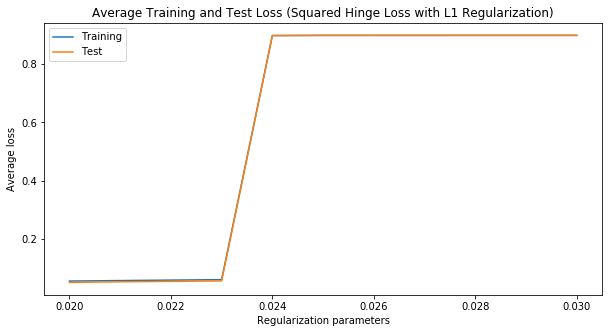

In [16]:
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Average Training and Test Loss (Squared Hinge Loss with L1 Regularization)")
plt.plot(reg_params1, train_ave_loss_L1_1, label="Training")
plt.plot(reg_params1, test_ave_loss_L1_1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

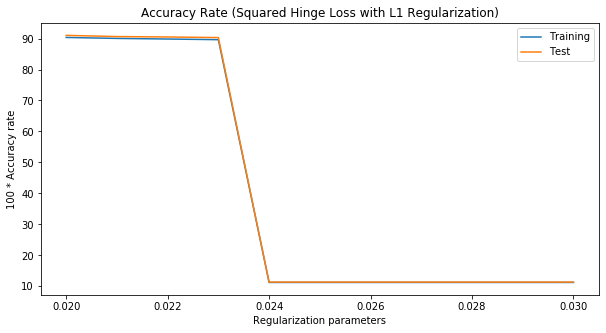

In [17]:
#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy Rate (Squared Hinge Loss with L1 Regularization)")
plt.plot(reg_params1, train_acc_L1_1, label="Training")
plt.plot(reg_params1, test_acc_L1_1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

# squared hinge loss with l2 regularization

In [18]:
#create an array of regularization parameters from 0 to 0.03 with step size 0.001
reg_params = np.linspace(0, 0.03, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_L2 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_L2 = []

#initiate a list storing training accuracy for different reg_param
train_acc_L2 = []

#initiate a list storing test accuracy for different reg_param
test_acc_L2 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_L2 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L2 = []

In [19]:
for reg_param in reg_params:
    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L2 norm of weight matrix on the last layer 
            l2_norm = torch.norm(model.fc_layers[-1].weight)**2
            
            
            #compute loss
            loss = nn.MultiMarginLoss(p=2)(output, target)  + reg_param*l2_norm
            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_L2.append(result_train[0])
    test_ave_loss_L2.append(result_test[0])
    train_acc_L2.append(result_train[1])
    test_acc_L2.append(result_test[1])
    matrix_norm_L2.append(np.linalg.norm(model.fc_layers[-1].weight.cpu().detach().numpy()))
    listoflist_L2.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.897108
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.868668
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.741624
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.282473
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.144298
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.087250
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.105387
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.044324
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.049693
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.078139
4.46s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.055671
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.032661
Regularization par

Regularization parameter: 0.003 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.046646
Regularization parameter: 0.003 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.039045
Regularization parameter: 0.003 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.074554
Regularization parameter: 0.003 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.084918
Regularization parameter: 0.003 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.048779
Regularization parameter: 0.003 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.095747
Regularization parameter: 0.003 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.046943
Regularization parameter: 0.003 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.053055
4.15s
Regularization parameter: 0.003 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.063026
Regularization parameter: 0.003 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.047385
Regularization parameter: 0.003 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.091315
Regularization parameter: 0.003 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.077673
Regularizatio

Regularization parameter: 0.006 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.086485
Regularization parameter: 0.006 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.083636
Regularization parameter: 0.006 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.065539
Regularization parameter: 0.006 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.053269
Regularization parameter: 0.006 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.050516
Regularization parameter: 0.006 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.062960
Regularization parameter: 0.006 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.052550
4.27s

Test set: Average loss: 0.0372, Accuracy: 9336/10000 (93%)

Regularization parameter: 0.007 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.920650
Regularization parameter: 0.007 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.892203
Regularization parameter: 0.007 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.771560
Regularization parameter: 0.007 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.322195
Regularization parameter: 0.007 Train

Regularization parameter: 0.010 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.338458
Regularization parameter: 0.010 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.187806
Regularization parameter: 0.010 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.130284
Regularization parameter: 0.010 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.146154
Regularization parameter: 0.010 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.084352
Regularization parameter: 0.010 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.088929
Regularization parameter: 0.010 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.116745
3.79s
Regularization parameter: 0.010 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.095195
Regularization parameter: 0.010 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.069391
Regularization parameter: 0.010 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.061785
Regularization parameter: 0.010 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.097848
Regularization parameter: 0.010 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.107117
Regularizati

Regularization parameter: 0.013 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.112406
Regularization parameter: 0.013 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.075103
Regularization parameter: 0.013 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.117877
Regularization parameter: 0.013 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.069389
Regularization parameter: 0.013 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.074604
4.26s
Regularization parameter: 0.013 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.084665
Regularization parameter: 0.013 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.068683
Regularization parameter: 0.013 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.108829
Regularization parameter: 0.013 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.095837
Regularization parameter: 0.013 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.093812
Regularization parameter: 0.013 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.074977
Regularization parameter: 0.013 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.062363
Regularizatio

Regularization parameter: 0.016 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.063860
Regularization parameter: 0.016 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.059989
Regularization parameter: 0.016 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.072150
Regularization parameter: 0.016 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.059781
4.01s

Test set: Average loss: 0.0405, Accuracy: 9294/10000 (93%)

Regularization parameter: 0.017 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.954281
Regularization parameter: 0.017 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.923838
Regularization parameter: 0.017 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.809666
Regularization parameter: 0.017 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.374998
Regularization parameter: 0.017 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.213073
Regularization parameter: 0.017 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.153673
Regularization parameter: 0.017 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.166717
Regularization parameter: 0.017 Train

Regularization parameter: 0.020 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.173896
Regularization parameter: 0.020 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.109832
Regularization parameter: 0.020 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.111814
Regularization parameter: 0.020 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.137777
4.21s
Regularization parameter: 0.020 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.115722
Regularization parameter: 0.020 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.086510
Regularization parameter: 0.020 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.078220
Regularization parameter: 0.020 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.114001
Regularization parameter: 0.020 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.120535
Regularization parameter: 0.020 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.082206
Regularization parameter: 0.020 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.123209
Regularization parameter: 0.020 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.074313
Regularizati

Regularization parameter: 0.023 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.075060
Regularization parameter: 0.023 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.079601
3.89s
Regularization parameter: 0.023 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.089728
Regularization parameter: 0.023 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.074060
Regularization parameter: 0.023 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.111330
Regularization parameter: 0.023 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.099069
Regularization parameter: 0.023 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.097280
Regularization parameter: 0.023 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.078870
Regularization parameter: 0.023 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.065311
Regularization parameter: 0.023 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.061578
Regularization parameter: 0.023 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.073135
Regularization parameter: 0.023 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.060051
4.08s

Test s

Regularization parameter: 0.026 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.060085
4.12s

Test set: Average loss: 0.0434, Accuracy: 9274/10000 (93%)

Regularization parameter: 0.027 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.987913
Regularization parameter: 0.027 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.953189
Regularization parameter: 0.027 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.842530
Regularization parameter: 0.027 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.423038
Regularization parameter: 0.027 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.243093
Regularization parameter: 0.027 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.179533
Regularization parameter: 0.027 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.187379
Regularization parameter: 0.027 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.121577
Regularization parameter: 0.027 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.121584
Regularization parameter: 0.027 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.146161
4.25s
Regularization parameter: 0.027

Regularization parameter: 0.030 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.148547
4.00s
Regularization parameter: 0.030 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.125912
Regularization parameter: 0.030 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.093535
Regularization parameter: 0.030 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.084870
Regularization parameter: 0.030 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.120697
Regularization parameter: 0.030 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.125835
Regularization parameter: 0.030 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.085994
Regularization parameter: 0.030 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.125576
Regularization parameter: 0.030 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.075429
Regularization parameter: 0.030 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.080215
4.09s
Regularization parameter: 0.030 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.090765
Regularization parameter: 0.030 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.075239
Regulariz

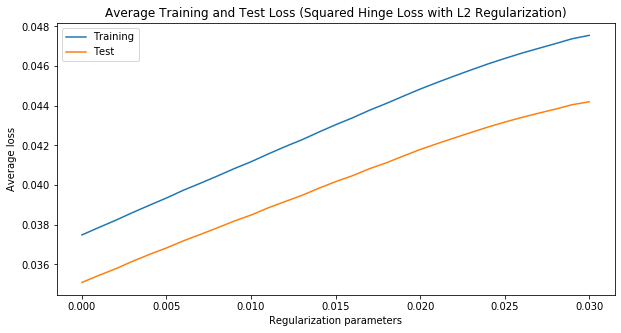

In [20]:
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Average Training and Test Loss (Squared Hinge Loss with L2 Regularization)")
plt.plot(reg_params, train_ave_loss_L2, label="Training")
plt.plot(reg_params, test_ave_loss_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

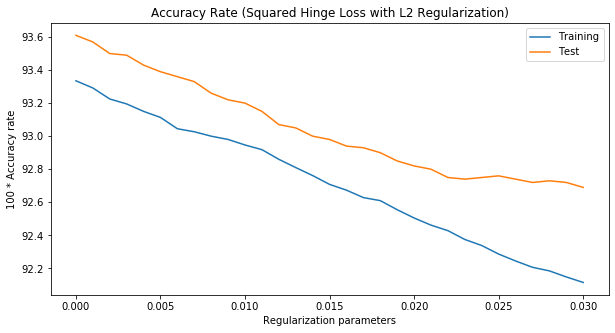

In [21]:
#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy Rate (Squared Hinge Loss with L2 Regularization)")
plt.plot(reg_params, train_acc_L2, label="Training")
plt.plot(reg_params, test_acc_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

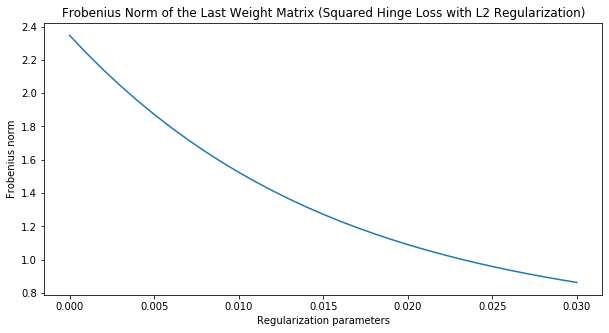

In [22]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Frobenius Norm of the Last Weight Matrix (Squared Hinge Loss with L2 Regularization)")
plt.plot(reg_params, matrix_norm_L2)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

# Softmax + MSE loss with l1 relularization

In [25]:
epoch = 3
#create an array of regularization parameters from 0 to 0.03 with step size 0.001
reg_params = np.linspace(0, 0.03, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_MSE_L1= []

#initiate a list storing test average loss for different reg_param
test_ave_loss_MSE_L1 = []

#initiate a list storing training accuracy for different reg_param
train_acc_MSE_L1 = []

#initiate a list storing test accuracy for different reg_param
test_acc_MSE_L1 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_MSE_L1 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L1 = []

In [30]:
for reg_param in reg_params:
    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L1 norm of weight matrix on the last layer 
            l1_norm = torch.norm(model.fc_layers[-1].weight, p=1)
            
            #softmax for MSE
            m = nn.Softmax(dim=1)
            output_softmax = m(output)
            target_onehot = torch.FloatTensor(target.size()[0], output.size()[1]).to(device)
            target_onehot.zero_()
            target_onehot.scatter_(1, target.view(-1,1), 1)

#             print('output_softmax', output_softmax.size())
#             print('target_onehot', target_onehot.size())
            
            #compute loss
            loss_f = torch.nn.MSELoss(reduce=True, size_average=True)
            loss = loss_f(output_softmax, target_onehot) + reg_param*l1_norm

            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_MSE_L1.append(result_train[0])
    test_ave_loss_MSE_L1.append(result_test[0])
    train_acc_MSE_L1.append(result_train[1])
    test_acc_MSE_L1.append(result_test[1])
    matrix_norm_MSE_L1.append(np.linalg.norm(model.fc_layers[-1].weight.cpu().detach().numpy()))
    listoflist_L1.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

/home/ty367/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.089950
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.090003
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.090005
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.090032
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.089779
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.089903
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.089903
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.089663
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.089808
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.089589
4.27s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.089511
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.089427
Regularization par

Regularization parameter: 0.003 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.090309
Regularization parameter: 0.003 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.090401
Regularization parameter: 0.003 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.090149
Regularization parameter: 0.003 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.090330
Regularization parameter: 0.003 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.090338
Regularization parameter: 0.003 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.090383
Regularization parameter: 0.003 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.090411
Regularization parameter: 0.003 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.090403
4.31s
Regularization parameter: 0.003 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.090236
Regularization parameter: 0.003 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.090371
Regularization parameter: 0.003 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.090322
Regularization parameter: 0.003 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.090276
Regularizatio

Regularization parameter: 0.006 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.091164
Regularization parameter: 0.006 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.091292
Regularization parameter: 0.006 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.091163
Regularization parameter: 0.006 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.091234
Regularization parameter: 0.006 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.091218
Regularization parameter: 0.006 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.091160
Regularization parameter: 0.006 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.091250
4.25s

Test set: Average loss: 0.8989, Accuracy: 1010/10000 (10%)

Regularization parameter: 0.007 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.701726
Regularization parameter: 0.007 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.095813
Regularization parameter: 0.007 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.091717
Regularization parameter: 0.007 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.091791
Regularization parameter: 0.007 Train

Regularization parameter: 0.010 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.093552
Regularization parameter: 0.010 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.093318
Regularization parameter: 0.010 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.093542
Regularization parameter: 0.010 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.093417
Regularization parameter: 0.010 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.093245
Regularization parameter: 0.010 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.093389
Regularization parameter: 0.010 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.093228
4.23s
Regularization parameter: 0.010 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.093393
Regularization parameter: 0.010 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.093385
Regularization parameter: 0.010 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.093404
Regularization parameter: 0.010 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.093195
Regularization parameter: 0.010 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.093315
Regularizati

Regularization parameter: 0.013 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.095593
Regularization parameter: 0.013 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.095420
Regularization parameter: 0.013 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.095599
Regularization parameter: 0.013 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.095659
Regularization parameter: 0.013 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.095698
4.20s
Regularization parameter: 0.013 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.095414
Regularization parameter: 0.013 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.095613
Regularization parameter: 0.013 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.095515
Regularization parameter: 0.013 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.095566
Regularization parameter: 0.013 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.095575
Regularization parameter: 0.013 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.095508
Regularization parameter: 0.013 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.095575
Regularizatio

Regularization parameter: 0.016 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.098372
Regularization parameter: 0.016 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.098412
Regularization parameter: 0.016 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.098356
Regularization parameter: 0.016 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.098359
4.15s

Test set: Average loss: 0.8990, Accuracy: 1010/10000 (10%)

Regularization parameter: 0.017 Train Epoch: 1 [0/60000 (0%)]	Loss: 1.575692
Regularization parameter: 0.017 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.101070
Regularization parameter: 0.017 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.100015
Regularization parameter: 0.017 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.099982
Regularization parameter: 0.017 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.099560
Regularization parameter: 0.017 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.099980
Regularization parameter: 0.017 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.099480
Regularization parameter: 0.017 Train

Regularization parameter: 0.020 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.103192
Regularization parameter: 0.020 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.103200
Regularization parameter: 0.020 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.103586
Regularization parameter: 0.020 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.103076
4.14s
Regularization parameter: 0.020 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.103138
Regularization parameter: 0.020 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.103160
Regularization parameter: 0.020 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.102980
Regularization parameter: 0.020 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.102922
Regularization parameter: 0.020 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.103335
Regularization parameter: 0.020 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.102876
Regularization parameter: 0.020 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.103357
Regularization parameter: 0.020 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.103178
Regularizati

Regularization parameter: 0.023 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.107511
Regularization parameter: 0.023 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.107273
3.82s
Regularization parameter: 0.023 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.107189
Regularization parameter: 0.023 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.107361
Regularization parameter: 0.023 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.107172
Regularization parameter: 0.023 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.107317
Regularization parameter: 0.023 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.107003
Regularization parameter: 0.023 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.107134
Regularization parameter: 0.023 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.107371
Regularization parameter: 0.023 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.107438
Regularization parameter: 0.023 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.107023
Regularization parameter: 0.023 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.107815
4.06s

Test s

Regularization parameter: 0.026 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.112676
3.70s

Test set: Average loss: 0.8989, Accuracy: 1010/10000 (10%)

Regularization parameter: 0.027 Train Epoch: 1 [0/60000 (0%)]	Loss: 2.449657
Regularization parameter: 0.027 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.117652
Regularization parameter: 0.027 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.115772
Regularization parameter: 0.027 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.115207
Regularization parameter: 0.027 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.115003
Regularization parameter: 0.027 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.114978
Regularization parameter: 0.027 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.114451
Regularization parameter: 0.027 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.114448
Regularization parameter: 0.027 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.114359
Regularization parameter: 0.027 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.114339
4.12s
Regularization parameter: 0.027

Regularization parameter: 0.030 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.120114
4.23s
Regularization parameter: 0.030 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.119996
Regularization parameter: 0.030 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.119332
Regularization parameter: 0.030 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.120348
Regularization parameter: 0.030 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.119009
Regularization parameter: 0.030 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.119055
Regularization parameter: 0.030 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.119531
Regularization parameter: 0.030 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.119755
Regularization parameter: 0.030 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.119836
Regularization parameter: 0.030 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.119609
4.36s
Regularization parameter: 0.030 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.120322
Regularization parameter: 0.030 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.118888
Regulariz

In [29]:
target

tensor([9, 6, 2, 7, 1, 6, 2, 7, 0, 6, 9, 7, 7, 3, 6, 7, 0, 6, 5, 1, 3, 3, 2, 0,
        8, 3, 4, 8, 2, 4, 9, 2, 6, 0, 8, 6, 9, 7, 3, 0, 1, 3, 6, 2, 9, 0, 5, 5,
        4, 6, 8, 4, 3, 8, 8, 7, 3, 3, 7, 8, 9, 3, 0, 1], device='cuda:0')

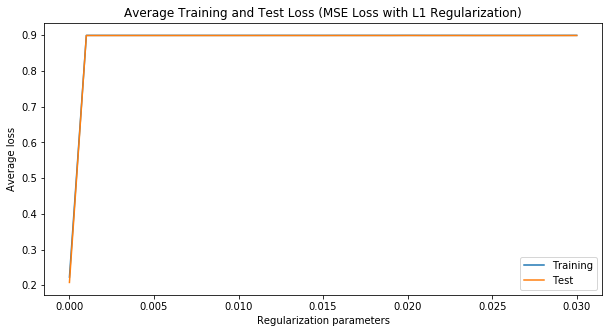

In [40]:
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Average Training and Test Loss (MSE Loss with L1 Regularization)")
plt.plot(reg_params, train_ave_loss_MSE_L1, label="Training")
plt.plot(reg_params, test_ave_loss_MSE_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

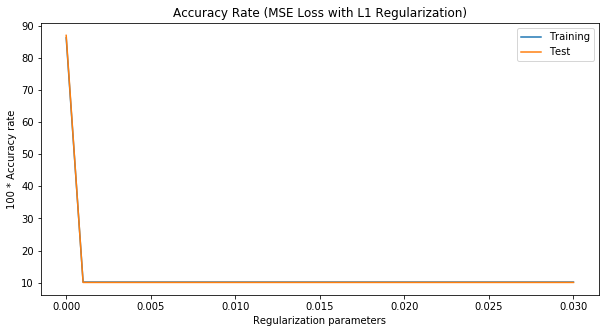

In [41]:
#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy Rate (MSE Loss with L1 Regularization)")
plt.plot(reg_params, train_acc_MSE_L1, label="Training")
plt.plot(reg_params, test_acc_MSE_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

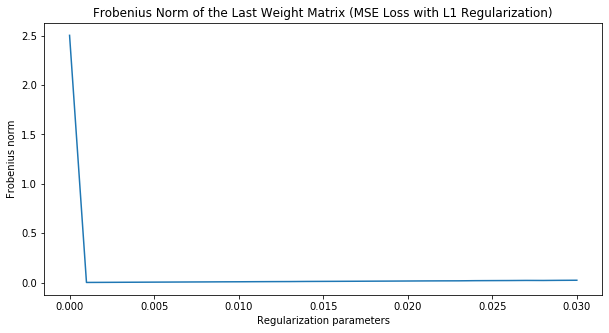

In [33]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Frobenius Norm of the Last Weight Matrix (MSE Loss with L1 Regularization)")
plt.plot(reg_params, matrix_norm_MSE_L1)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

# # Softmax + MSE loss with l2 relularization

In [34]:
epoch = 3
#create an array of regularization parameters from 0 to 0.03 with step size 0.001
reg_params = np.linspace(0, 0.03, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_MSE_L2= []

#initiate a list storing test average loss for different reg_param
test_ave_loss_MSE_L2 = []

#initiate a list storing training accuracy for different reg_param
train_acc_MSE_L2 = []

#initiate a list storing test accuracy for different reg_param
test_acc_MSE_L2 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_MSE_L2 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L2 = []

In [ ]:
for reg_param in reg_params:
    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
                       #compute the L2 norm of weight matrix on the last layer 
            l2_norm = torch.norm(model.fc_layers[-1].weight)**2
            
            #softmax for MSE
            m = nn.Softmax(dim=1)
            output_softmax = m(output)
            target_onehot = torch.FloatTensor(target.size()[0], output.size()[1]).to(device)
            target_onehot.zero_()
            target_onehot.scatter_(1, target.view(-1,1), 1)

#             print('output_softmax', output_softmax.size())
#             print('target_onehot', target_onehot.size())
            
            #compute loss
            loss_f = torch.nn.MSELoss(reduce=True, size_average=True)
            loss = loss_f(output_softmax, target_onehot) + reg_param*l2_norm

            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_MSE_L2.append(result_train[0])
    test_ave_loss_MSE_L2.append(result_test[0])
    train_acc_MSE_L2.append(result_train[1])
    test_acc_MSE_L2.append(result_test[1])
    matrix_norm_MSE_L2.append(np.linalg.norm(model.fc_layers[-1].cpu().weight.detach().numpy()))
    listoflist_L2.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.089950
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.090003
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.090005
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.090032
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.089779
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.089903
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.089903
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.089663
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.089808
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.089589
4.27s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.089511
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.089427
Regularization par

Regularization parameter: 0.003 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.092523
Regularization parameter: 0.003 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.092282
Regularization parameter: 0.003 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.091735
Regularization parameter: 0.003 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.091702
Regularization parameter: 0.003 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.091476
Regularization parameter: 0.003 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.091335
Regularization parameter: 0.003 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.091127
Regularization parameter: 0.003 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.091010
4.15s
Regularization parameter: 0.003 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.090770
Regularization parameter: 0.003 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.090589
Regularization parameter: 0.003 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.090459
Regularization parameter: 0.003 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.090292
Regularizatio

Regularization parameter: 0.006 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.089973
Regularization parameter: 0.006 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.090056
Regularization parameter: 0.006 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.089925
Regularization parameter: 0.006 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.089942
Regularization parameter: 0.006 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.089929
Regularization parameter: 0.006 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.089914
Regularization parameter: 0.006 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.089881
4.50s

Test set: Average loss: 0.8776, Accuracy: 1342/10000 (13%)

Regularization parameter: 0.007 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.113492
Regularization parameter: 0.007 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.108187
Regularization parameter: 0.007 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.103708
Regularization parameter: 0.007 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.100387
Regularization parameter: 0.007 Train

Regularization parameter: 0.010 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.100359
Regularization parameter: 0.010 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.096698
Regularization parameter: 0.010 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.094592
Regularization parameter: 0.010 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.093075
Regularization parameter: 0.010 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.091900
Regularization parameter: 0.010 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.091383
Regularization parameter: 0.010 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.090787
4.23s
Regularization parameter: 0.010 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.090504
Regularization parameter: 0.010 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.090360
Regularization parameter: 0.010 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.090309
Regularization parameter: 0.010 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.089982
Regularization parameter: 0.010 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.090102
Regularizati

Regularization parameter: 0.013 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.090021
Regularization parameter: 0.013 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.090022
Regularization parameter: 0.013 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.090061
Regularization parameter: 0.013 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.090072
Regularization parameter: 0.013 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.090078
4.09s
Regularization parameter: 0.013 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.089921
Regularization parameter: 0.013 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.090028
Regularization parameter: 0.013 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.089983
Regularization parameter: 0.013 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.089942
Regularization parameter: 0.013 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.090044
Regularization parameter: 0.013 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.089954
Regularization parameter: 0.013 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.089994
Regularizatio

Regularization parameter: 0.016 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.090004
Regularization parameter: 0.016 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.089986
Regularization parameter: 0.016 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.089937
Regularization parameter: 0.016 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.089994
4.10s

Test set: Average loss: 0.8950, Accuracy: 1010/10000 (10%)

Regularization parameter: 0.017 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.147124
Regularization parameter: 0.017 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.120231
Regularization parameter: 0.017 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.104983
Regularization parameter: 0.017 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.097508
Regularization parameter: 0.017 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.093550
Regularization parameter: 0.017 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.091888
Regularization parameter: 0.017 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.090965
Regularization parameter: 0.017 Train

Regularization parameter: 0.020 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.090561
Regularization parameter: 0.020 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.090126
Regularization parameter: 0.020 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.090154
Regularization parameter: 0.020 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.089952
4.42s
Regularization parameter: 0.020 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.089948
Regularization parameter: 0.020 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.089994
Regularization parameter: 0.020 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.090072
Regularization parameter: 0.020 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.089831
Regularization parameter: 0.020 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.090003
Regularization parameter: 0.020 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.090014
Regularization parameter: 0.020 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.090059
Regularization parameter: 0.020 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.090079
Regularizati

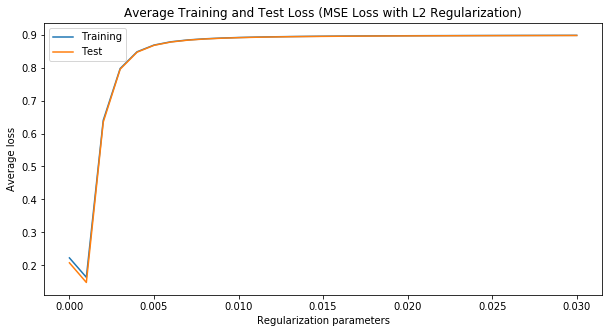

In [42]:
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Average Training and Test Loss (MSE Loss with L2 Regularization)")
plt.plot(reg_params, train_ave_loss_MSE_L2, label="Training")
plt.plot(reg_params, test_ave_loss_MSE_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

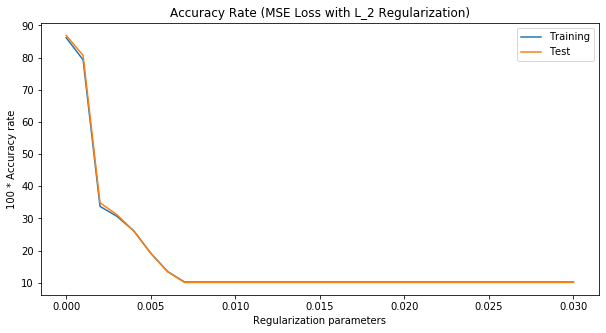

In [43]:
#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy Rate (MSE Loss with L_2 Regularization)")
plt.plot(reg_params, train_acc_MSE_L2, label="Training")
plt.plot(reg_params, test_acc_MSE_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

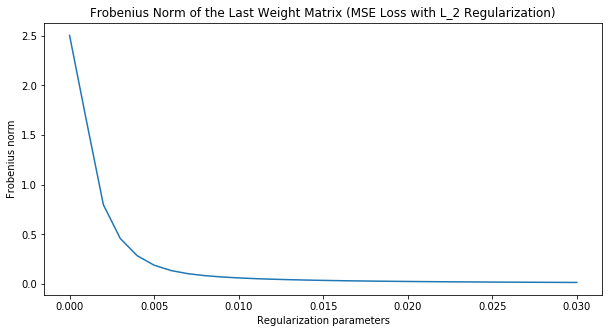

In [44]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Frobenius Norm of the Last Weight Matrix (MSE Loss with L_2 Regularization)")
plt.plot(reg_params, matrix_norm_MSE_L2)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

# Cross entropy loss + early stop

In [13]:
from torchvision import datasets

In [41]:
from torch.utils.data.sampler import SubsetRandomSampler
def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root='./mnist_png/training', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='./mnist_png/testing',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

In [42]:
model = NetSeq()


In [43]:
# specify loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    

In [44]:
patience_par = np.linspace(1, 20, num=20, endpoint=True)

In [45]:
patience_par

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

In [46]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss



In [47]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [48]:
#initiate a list storing training average loss for different reg_param
train_loss_early= []

#initiate a list storing test average loss for different reg_param
test_loss_early = []

#initiate a list storing training accuracy for different reg_param
train_acc_early = []

#initiate a list storing test accuracy for different reg_param
test_acc_early = []

#initiate a list storing matrix norm for different reg_param
#matrix_norm_MSE_L2 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L2 = []

In [49]:
for patience in patience_par:
    batch_size = 64
    n_epochs = 30
    train_loader, test_loader, valid_loader = create_datasets(batch_size)
    model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)
    train_loss_early.append(train_loss)
    
    batch_size = 1000
    n_epochs = 3
    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # prep model for evaluation

    for data, target in test_loader:
    #     print(len(target.data), batch_size)
    #     if len(target.data) != batch_size:
    #         break
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
    #     print(pred)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    print('class_correct', class_correct)
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    test_loss_early.append(test_loss)
    
    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
    #     else:
    #         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    test_acc_early.append(100. * np.sum(class_correct) / np.sum(class_total))

[ 1/30] train_loss: 1.76121 valid_loss: 0.49268
Validation loss decreased (inf --> 0.492682).  Saving model ...
[ 2/30] train_loss: 0.34056 valid_loss: 0.28238
Validation loss decreased (0.492682 --> 0.282381).  Saving model ...
[ 3/30] train_loss: 0.22250 valid_loss: 0.21386
Validation loss decreased (0.282381 --> 0.213862).  Saving model ...
[ 4/30] train_loss: 0.16524 valid_loss: 0.16211
Validation loss decreased (0.213862 --> 0.162110).  Saving model ...
[ 5/30] train_loss: 0.13258 valid_loss: 0.12775
Validation loss decreased (0.162110 --> 0.127752).  Saving model ...
[ 6/30] train_loss: 0.11112 valid_loss: 0.11681
Validation loss decreased (0.127752 --> 0.116813).  Saving model ...
[ 7/30] train_loss: 0.09733 valid_loss: 0.10799
Validation loss decreased (0.116813 --> 0.107988).  Saving model ...
[ 8/30] train_loss: 0.08769 valid_loss: 0.08896
Validation loss decreased (0.107988 --> 0.088961).  Saving model ...
[ 9/30] train_loss: 0.07970 valid_loss: 0.08386
Validation loss decre

class_correct [975.0, 1126.0, 1021.0, 998.0, 975.0, 881.0, 941.0, 1017.0, 958.0, 985.0]
Test Loss: 0.037290

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 98% (1021/1032)
Test Accuracy of     3: 98% (998/1010)
Test Accuracy of     4: 99% (975/982)
Test Accuracy of     5: 98% (881/892)
Test Accuracy of     6: 98% (941/958)
Test Accuracy of     7: 98% (1017/1028)
Test Accuracy of     8: 98% (958/974)
Test Accuracy of     9: 97% (985/1009)

Test Accuracy (Overall): 98% (9877/10000)
[ 1/30] train_loss: 0.02776 valid_loss: 0.02494
Validation loss decreased (inf --> 0.024945).  Saving model ...
[ 2/30] train_loss: 0.02641 valid_loss: 0.02533
EarlyStopping counter: 1 out of 7.0
[ 3/30] train_loss: 0.02442 valid_loss: 0.02895
EarlyStopping counter: 2 out of 7.0
[ 4/30] train_loss: 0.02403 valid_loss: 0.02567
EarlyStopping counter: 3 out of 7.0
[ 5/30] train_loss: 0.02290 valid_loss: 0.02640
EarlyStopping counter: 4 out of 7.0
[ 6/30] trai

[ 6/30] train_loss: 0.00993 valid_loss: 0.01477
EarlyStopping counter: 1 out of 11.0
[ 7/30] train_loss: 0.00928 valid_loss: 0.01541
EarlyStopping counter: 2 out of 11.0
[ 8/30] train_loss: 0.00890 valid_loss: 0.01709
EarlyStopping counter: 3 out of 11.0
[ 9/30] train_loss: 0.00860 valid_loss: 0.01562
EarlyStopping counter: 4 out of 11.0
[10/30] train_loss: 0.00802 valid_loss: 0.01517
EarlyStopping counter: 5 out of 11.0
[11/30] train_loss: 0.00733 valid_loss: 0.02175
EarlyStopping counter: 6 out of 11.0
[12/30] train_loss: 0.00725 valid_loss: 0.01776
EarlyStopping counter: 7 out of 11.0
[13/30] train_loss: 0.00730 valid_loss: 0.01542
EarlyStopping counter: 8 out of 11.0
[14/30] train_loss: 0.00665 valid_loss: 0.01987
EarlyStopping counter: 9 out of 11.0
[15/30] train_loss: 0.00627 valid_loss: 0.01502
EarlyStopping counter: 10 out of 11.0
[16/30] train_loss: 0.00589 valid_loss: 0.01802
EarlyStopping counter: 11 out of 11.0
Early stopping
class_correct [975.0, 1129.0, 1025.0, 997.0, 974

[12/30] train_loss: 0.00493 valid_loss: 0.01134
EarlyStopping counter: 11 out of 15.0
[13/30] train_loss: 0.00484 valid_loss: 0.01108
EarlyStopping counter: 12 out of 15.0
[14/30] train_loss: 0.00440 valid_loss: 0.01216
EarlyStopping counter: 13 out of 15.0
[15/30] train_loss: 0.00408 valid_loss: 0.01094
EarlyStopping counter: 14 out of 15.0
[16/30] train_loss: 0.00421 valid_loss: 0.01344
EarlyStopping counter: 15 out of 15.0
Early stopping
class_correct [975.0, 1130.0, 1024.0, 997.0, 964.0, 874.0, 949.0, 1014.0, 958.0, 994.0]
Test Loss: 0.038130

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 99% (1024/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 98% (964/982)
Test Accuracy of     5: 97% (874/892)
Test Accuracy of     6: 99% (949/958)
Test Accuracy of     7: 98% (1014/1028)
Test Accuracy of     8: 98% (958/974)
Test Accuracy of     9: 98% (994/1009)

Test Accuracy (Overall): 98% (9879/10000)
[ 1/30] train_l

[ 9/30] train_loss: 0.00423 valid_loss: 0.01015
EarlyStopping counter: 7 out of 19.0
[10/30] train_loss: 0.00427 valid_loss: 0.00922
EarlyStopping counter: 8 out of 19.0
[11/30] train_loss: 0.00398 valid_loss: 0.01032
EarlyStopping counter: 9 out of 19.0
[12/30] train_loss: 0.00368 valid_loss: 0.01153
EarlyStopping counter: 10 out of 19.0
[13/30] train_loss: 0.00373 valid_loss: 0.00960
EarlyStopping counter: 11 out of 19.0
[14/30] train_loss: 0.00335 valid_loss: 0.01054
EarlyStopping counter: 12 out of 19.0
[15/30] train_loss: 0.00346 valid_loss: 0.01036
EarlyStopping counter: 13 out of 19.0
[16/30] train_loss: 0.00318 valid_loss: 0.01027
EarlyStopping counter: 14 out of 19.0
[17/30] train_loss: 0.00307 valid_loss: 0.01015
EarlyStopping counter: 15 out of 19.0
[18/30] train_loss: 0.00342 valid_loss: 0.01068
EarlyStopping counter: 16 out of 19.0
[19/30] train_loss: 0.00279 valid_loss: 0.01053
EarlyStopping counter: 17 out of 19.0
[20/30] train_loss: 0.00281 valid_loss: 0.01069
EarlyStop

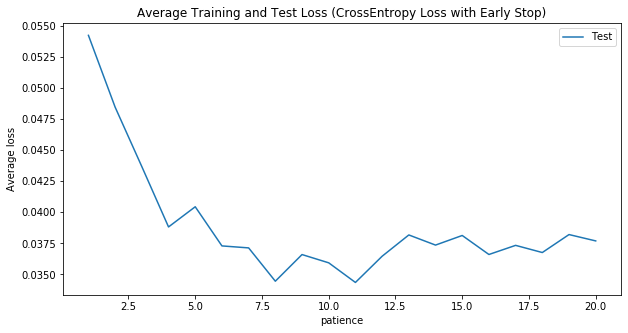

In [50]:
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Average Training and Test Loss (CrossEntropy Loss with Early Stop)")
#plt.plot(patience_par, train_loss_early, label="Training")
plt.plot(patience_par, test_loss_early, label="Test")
plt.xlabel("patience")
plt.ylabel("Average loss")
plt.legend()
plt.show()

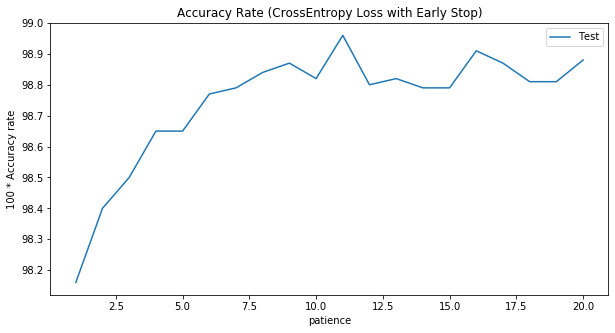

In [51]:
#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy Rate (CrossEntropy Loss with Early Stop)")
#plt.plot(reg_params, train_acc_MSE_L2, label="Training")
plt.plot(patience_par, test_acc_early, label="Test")
plt.xlabel("patience")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()